# Bitcoin Price Prediction Analysis
## Mathematical Foundation and Results

### Model Architecture
The price prediction model combines Monte Carlo simulation with technical indicators using the following components:

1. **Stochastic Differential Equation (SDE)**:
   $dS_t = \mu S_t dt + \sigma S_t dW_t$
   
   where:
   - $S_t$ is the asset price at time $t$
   - $\mu$ is the drift coefficient
   - $\sigma$ is the volatility
   - $W_t$ is a Wiener process

2. **Technical Indicators**:
   - RSI: $RSI = 100 - \frac{100}{1 + \frac{\sum_{i=1}^n UP_i/n}{\sum_{i=1}^n DOWN_i/n}}$
   - CCI: $CCI = \frac{TP - SMA(TP)_{20}}{0.015 \times MD}$

3. **Fourier Seasonality**:
   $S(t) = \sum_{k=1}^n [a_k \cos(\frac{2\pi kt}{T}) + b_k \sin(\frac{2\pi kt}{T})]$

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.graph_objects as go
from pathlib import Path
from scipy import stats

%matplotlib inline
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 2
})

In [53]:
def load_results():
    try:
        notebook_dir = Path().absolute()
        logs_path = notebook_dir / 'logs'
        safe_path = './logs'
        print(f"Looking for log files in: {safe_path}")
        
        if not logs_path.exists():
            print(f"Creating logs directory at: {safe_path}")
            logs_path.mkdir(parents=True, exist_ok=True)
            
        accuracy_file = logs_path / 'accuracy_results.csv'
        predictions_file = logs_path / 'future_predictions.csv'
        
        if not accuracy_file.exists() or not predictions_file.exists():
            raise FileNotFoundError(f"Missing required files in {safe_path}")
        accuracy_df = pd.read_csv(
            accuracy_file,
            comment='#',
            sep=r'\s*\|\s*',
            engine='python',
            names=['Date', 'Actual', 'Predicted', 'Error_Pct'],
            skiprows=6
        )

        predictions_df = pd.read_csv(
            predictions_file,
            comment='#',
            sep=r'\s*\|\s*',
            engine='python',
            names=['Date', 'Predicted_Price', 'Lower_Bound', 'Upper_Bound'],
            skiprows=6 
        )
        
        for df in [accuracy_df, predictions_df]:
            df['Date'] = pd.to_datetime(df['Date'])
            numeric_cols = df.columns.difference(['Date'])
            df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
        
        print("\nLoaded data successfully with columns:")
        print("Accuracy:", accuracy_df.columns.tolist())
        print("Predictions:", predictions_df.columns.tolist())
        
        return accuracy_df, predictions_df
        
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        print(f"Check if files exist and are readable in logs directory")
        return None, None

In [54]:
accuracy_df, predictions_df = load_results()

if accuracy_df is not None and predictions_df is not None:
    accuracy_df['Date'] = pd.to_datetime(accuracy_df['Date'])
    predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])
    
    print("Data loaded successfully!")
    print(f"Accuracy data shape: {accuracy_df.shape}")
    print(f"Prediction data shape: {predictions_df.shape}")
    print("\nAccuracy Data Preview:")
    display(accuracy_df.head())
    print("\nPredictions Data Preview:")
    display(predictions_df.head())

Looking for log files in: ./logs

Loaded data successfully with columns:
Accuracy: ['Date', 'Actual', 'Predicted', 'Error_Pct']
Predictions: ['Date', 'Predicted_Price', 'Lower_Bound', 'Upper_Bound']
Data loaded successfully!
Accuracy data shape: (703, 4)
Prediction data shape: (26, 4)

Accuracy Data Preview:


,Date,Actual,Predicted,Error_Pct
0,2022-12-28,16547.31,16707.19,0.97
1,2022-12-29,16633.47,16619.46,0.08
2,2022-12-30,16607.48,16523.40,0.51
3,2022-12-31,16542.40,16602.43,0.36
4,2023-01-01,16616.75,16557.44,0.36



Predictions Data Preview:


,Date,Predicted_Price,Lower_Bound,Upper_Bound
0,2024-12-04,98559.83,88546.83,109313.09
1,2024-12-05,98854.96,87843.59,110783.83
2,2024-12-06,99121.39,87216.52,112125.83
3,2024-12-07,99310.81,86412.97,113581.93
4,2024-12-08,99689.44,85868.70,114835.84


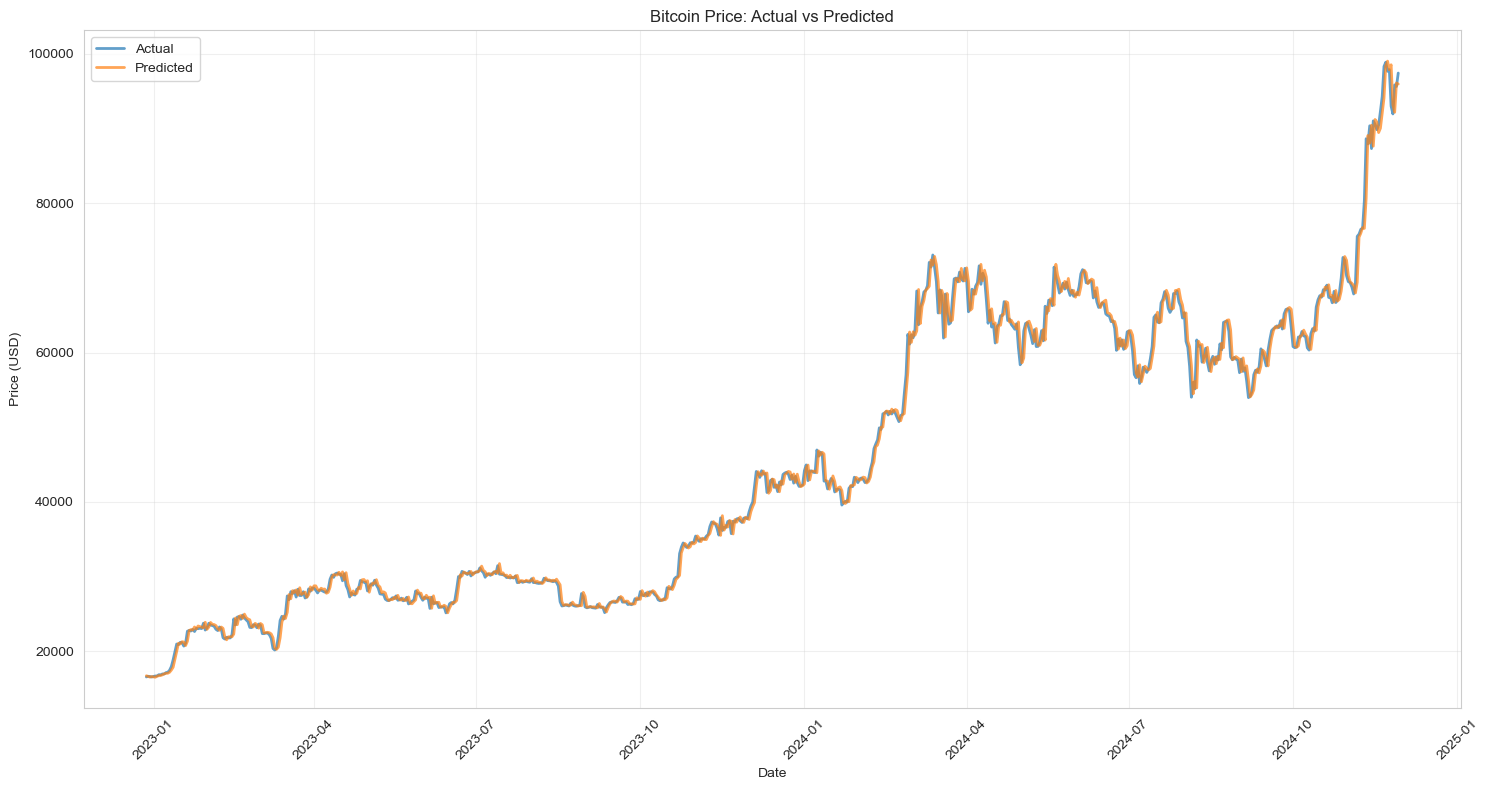

In [55]:
def plot_price_comparison():
    plt.figure(figsize=(15, 8))
    plt.plot(accuracy_df['Date'], accuracy_df['Actual'], label='Actual', alpha=0.7)
    plt.plot(accuracy_df['Date'], accuracy_df['Predicted'], label='Predicted', alpha=0.7)
    plt.title('Bitcoin Price: Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if accuracy_df is not None:
    plot_price_comparison()

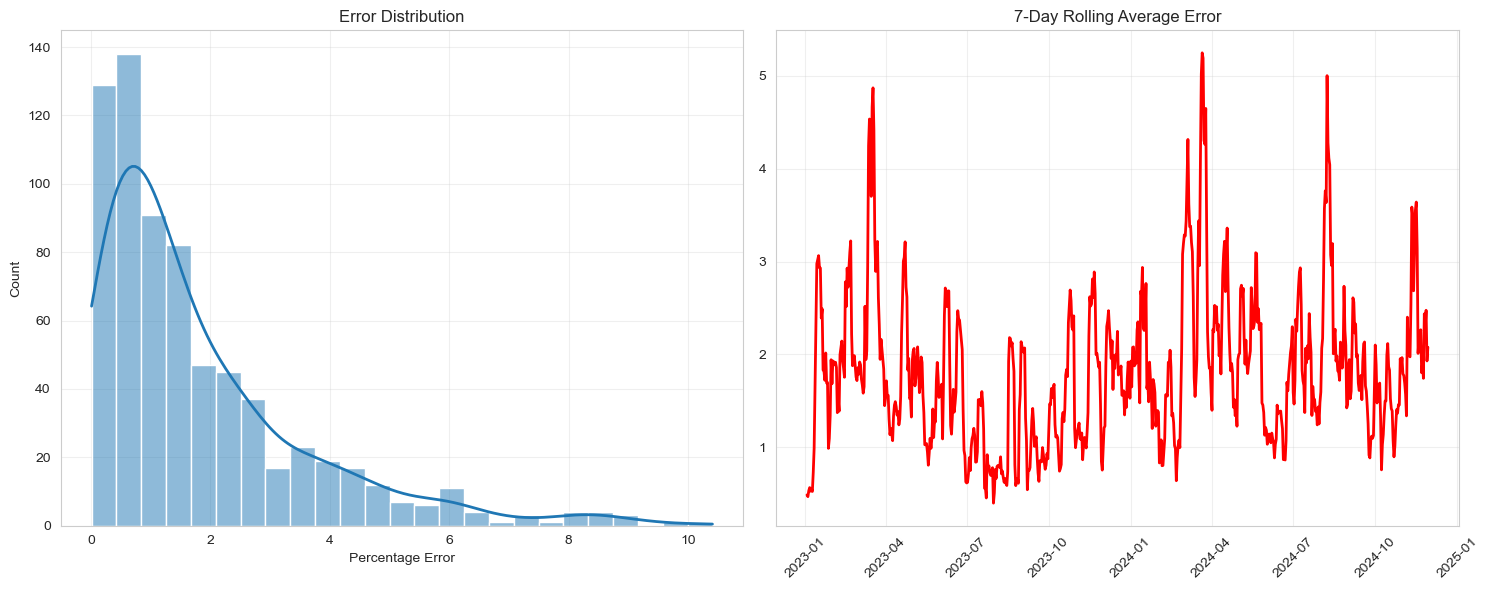

In [56]:
def plot_error_analysis():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Error Distribution
    sns.histplot(accuracy_df['Error_Pct'], kde=True, ax=ax1)
    ax1.set_title('Error Distribution')
    ax1.set_xlabel('Percentage Error')
    
    # Rolling Error
    rolling_error = accuracy_df['Error_Pct'].rolling(window=7).mean()
    ax2.plot(accuracy_df['Date'], rolling_error, color='red')
    ax2.set_title('7-Day Rolling Average Error')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

if accuracy_df is not None:
    plot_error_analysis()

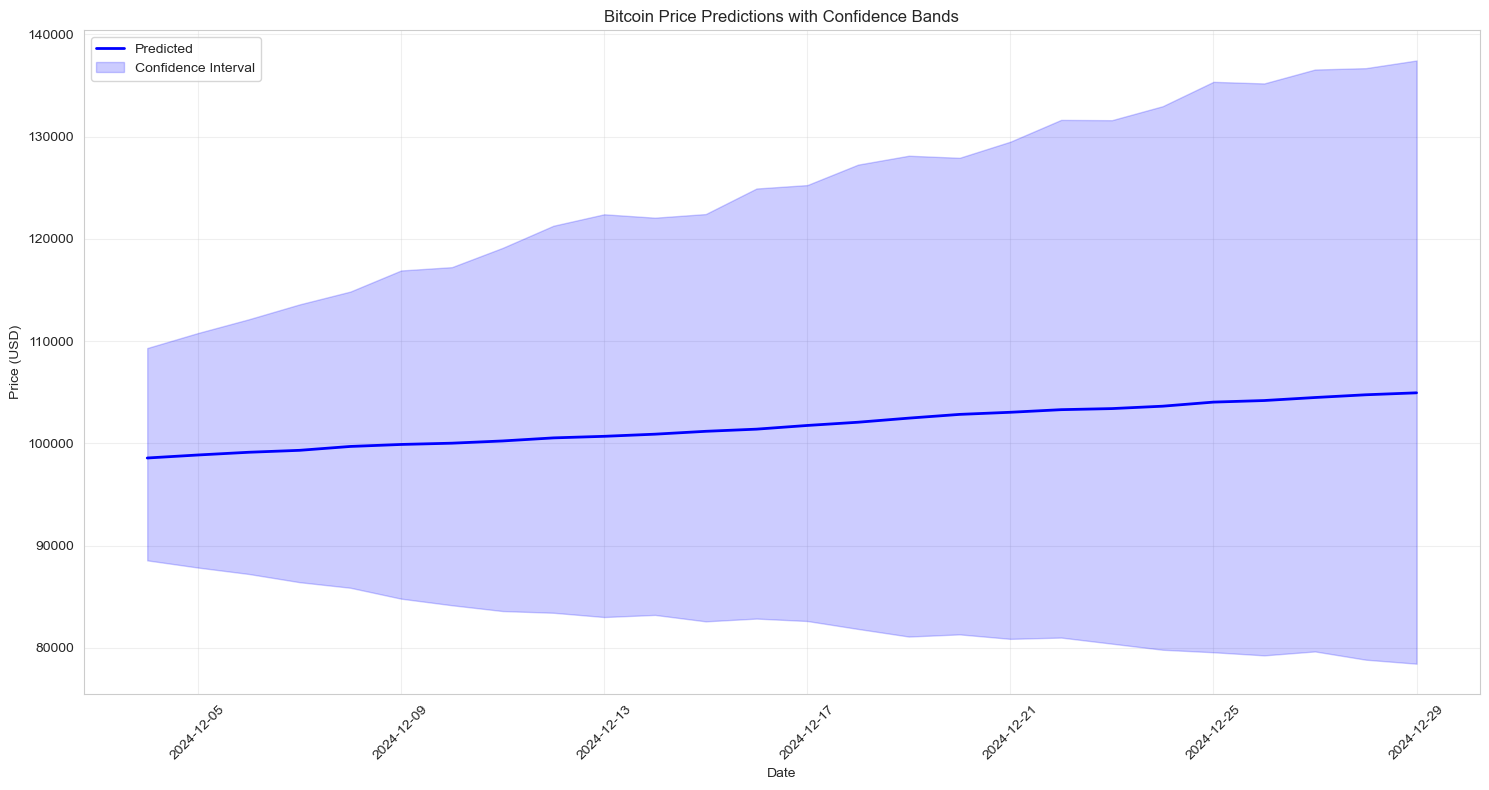

In [57]:
def plot_future_predictions():
    plt.figure(figsize=(15, 8))
    
    plt.plot(predictions_df['Date'], predictions_df['Predicted_Price'],
             label='Predicted', color='blue')
    plt.fill_between(predictions_df['Date'],
                     predictions_df['Lower_Bound'],
                     predictions_df['Upper_Bound'],
                     alpha=0.2, color='blue',
                     label='Confidence Interval')
    
    plt.title('Bitcoin Price Predictions with Confidence Bands')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if predictions_df is not None:
    plot_future_predictions()

### Performance Metrics

The model's performance is evaluated using multiple metrics:

1. **RMSE (Root Mean Square Error)**:
   $RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n (\hat{y}_i - y_i)^2}$

2. **MAPE (Mean Absolute Percentage Error)**:
   $MAPE = \frac{100\%}{n}\sum_{i=1}^n |\frac{\hat{y}_i - y_i}{y_i}|$

3. **R² Score**:
   $R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$

<Figure size 1500x1000 with 0 Axes>

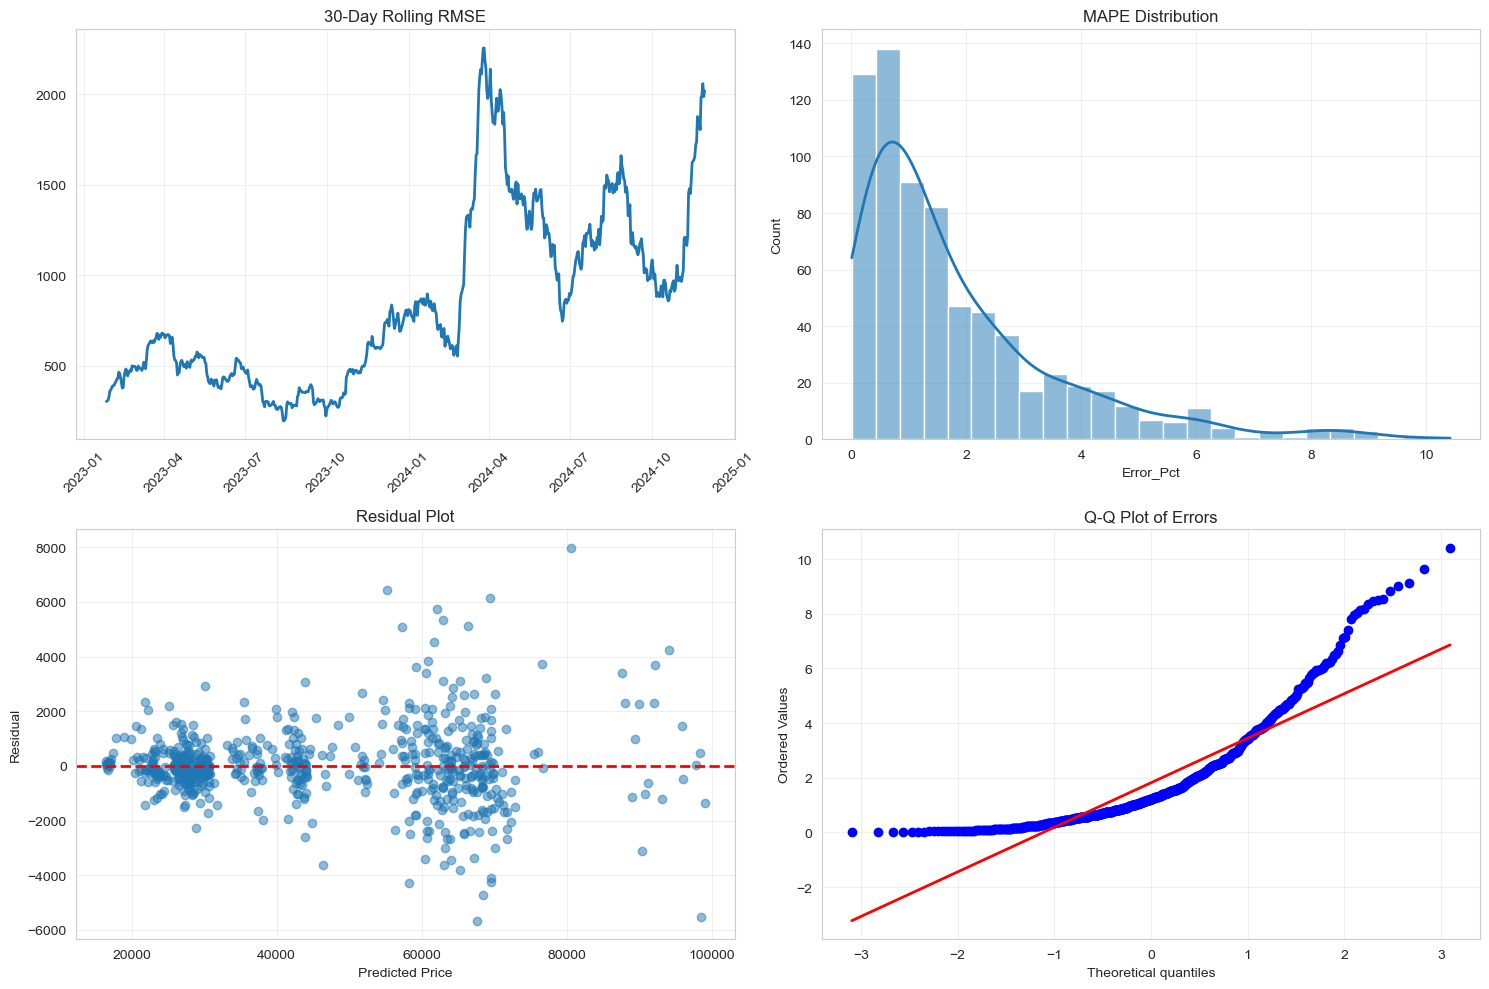

In [58]:
def analyze_performance_metrics(df):
    plt.figure(figsize=(15, 10))
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2)
    
    # RMSE over time
    ax1 = fig.add_subplot(gs[0, 0])
    rolling_rmse = np.sqrt((df['Actual'] - df['Predicted'])**2).rolling(30).mean()
    ax1.plot(df['Date'], rolling_rmse)
    ax1.set_title('30-Day Rolling RMSE')
    ax1.tick_params(axis='x', rotation=45)
    
    # MAPE distribution
    ax2 = fig.add_subplot(gs[0, 1])
    sns.histplot(data=df['Error_Pct'].dropna(), kde=True, ax=ax2)
    ax2.set_title('MAPE Distribution')
    
    # Residual plot
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.scatter(df['Predicted'], df['Actual'] - df['Predicted'], alpha=0.5)
    ax3.axhline(y=0, color='r', linestyle='--')
    ax3.set_title('Residual Plot')
    ax3.set_xlabel('Predicted Price')
    ax3.set_ylabel('Residual')
    
    # Q-Q plot
    ax4 = fig.add_subplot(gs[1, 1])
    stats.probplot(df['Error_Pct'].dropna(), dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot of Errors')
    
    plt.tight_layout()
    plt.show()

if accuracy_df is not None:
    analyze_performance_metrics(accuracy_df)

### Confidence Interval Analysis

The prediction confidence intervals are calculated using:

$CI = \hat{y} \pm z_{\alpha/2} \cdot \sigma_{\hat{y}}$

where:
- $z_{\alpha/2}$ is the critical value (1.96 for 95% CI)
- $\sigma_{\hat{y}}$ is the standard error of prediction

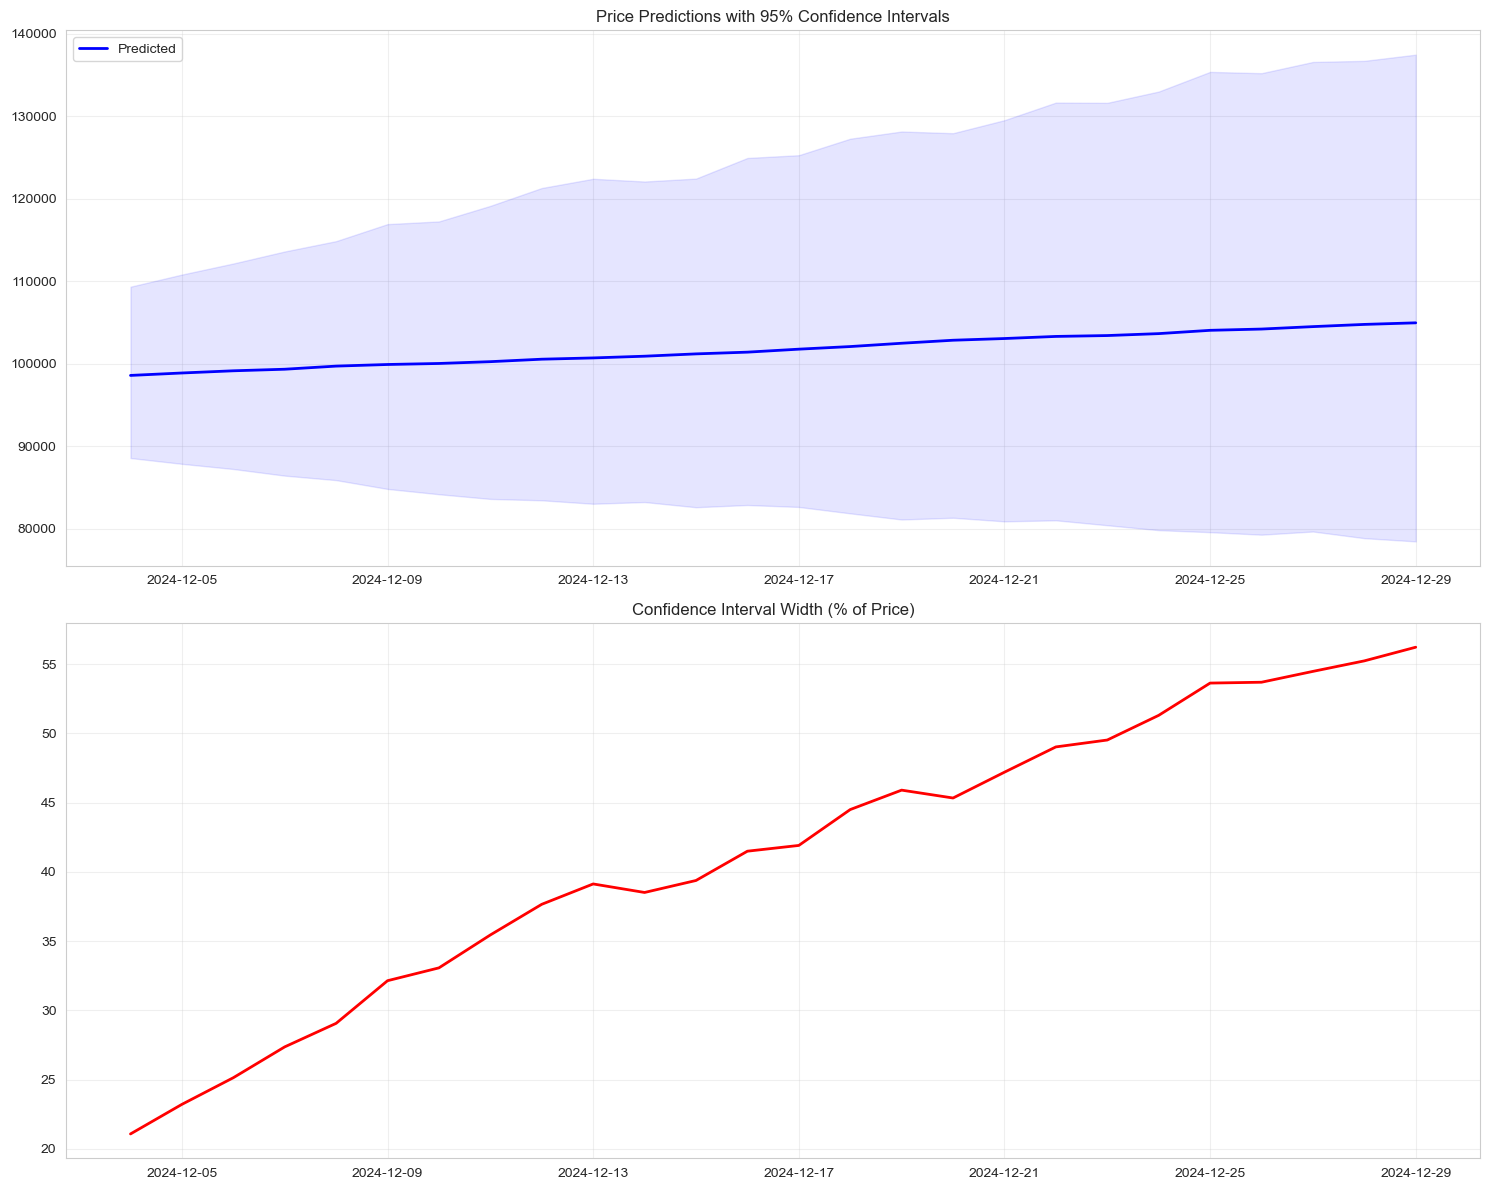

In [59]:
def plot_confidence_analysis():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Confidence interval coverage
    actual = predictions_df['Predicted_Price']
    lower = predictions_df['Lower_Bound']
    upper = predictions_df['Upper_Bound']
    
    ax1.plot(predictions_df['Date'], actual, 'b-', label='Predicted')
    ax1.fill_between(predictions_df['Date'], lower, upper, color='b', alpha=0.1)
    ax1.set_title('Price Predictions with 95% Confidence Intervals')
    ax1.legend()
    
    # Interval width analysis
    interval_width = (upper - lower) / actual * 100
    ax2.plot(predictions_df['Date'], interval_width, 'r-')
    ax2.set_title('Confidence Interval Width (% of Price)')
    
    plt.tight_layout()
    plt.show()

if predictions_df is not None:
    plot_confidence_analysis()

### Technical Analysis Integration

The model incorporates technical indicators through a weighted influence factor:

$\mu_{adj} = \mu \cdot (w_{RSI}f_{RSI} + w_{CCI}f_{CCI})$

where $w_i$ are weights and $f_i$ are indicator factors derived from:

- RSI zones: Oversold (<30), Neutral (30-70), Overbought (>70)
- CCI zones: Oversold (<-100), Neutral (-100 to 100), Overbought (>100)